In [1]:
# Import packages.
import cvxpy as cp
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

# Define some standard matrices
eye3 = np.array([[1],[1],[1]])

# Define the following properties:
m_0 = 2000 # initial mass [kg]
m_f = 300  # final   mass [kg]

T_max = 24000 # Max Thrust [N]
rho_1 = 0.2 * T_max # Lower Thrust Limit
rho_2 = 0.8 * T_max # Upper Thrust Limit

alpha = 5e-4 # fuel consumption rate [s/m]

theta = 45 * np.pi / 180 # max thrust angle constraint [rad]

r_0 = np.array([2400, 450, -330]) # Initial Position
dr_0 = np.array([-10, -40, 10]) # Initial Velocity
x_state = np.concatenate([r_0, dr_0]) # State Vector

q = np.array([0, 0]) # target landing site in guidance frame [m]
g = np.array([-3.71, 0, 0]) # Mars constant gravity vector [m/s^2]
w = np.array([2.53e-5, 0, 6.62e-5]) # Mars constant rotational velocity [rad/s]

# Define the S matrix
S_w = np.array([[ 0, -w[2], w[1]],
                [ w[2], 0, -w[1]],
                [-w[1], w[0], 0]])

# Construct the A matrix
A_w_top = np.concatenate([np.zeros([3,3]), np.eye(3)], 1)
A_w_bot = np.concatenate( [-np.power(S_w,2), -2 * S_w], 1 )
A_w = np.concatenate( [A_w_top, A_w_bot], 0 )

# Construct the B matrix
B = np.concatenate([np.zeros([3,3]),np.eye(3)])

# Define the E matrix
e1 = np.array([1, 0, 0]) 
e2 = np.array([0, 1, 0]) 
e3 = np.array([0, 0, 1]) 
E = np.concatenate([[e2],[e3]], axis=0)

# Define the body axis variable which the thrust vector is constrained against
n_hat = np.array([1,0,0]) # Likely correct

# Glide Constraints
theta = 45 * np.pi / 180 # max thrust angle constraint [rad]
gamma_gs = 30 * np.pi / 180 # glide constraint [rad]

c = e1 / np.tan(gamma_gs)

# Velocity Constraints
V_max = 100 # m/s

# Define and solve the CVXPY problem.
n_idx = 50 # number of timesteps
tf = 60  # final time [s]
w_idx = 5 # Timesteps between critic parameter updates

tstep = tf / n_idx

# Create a time vector from 0 to tf with n intervals
ts, delt = np.linspace(0,tf,n_idx,endpoint=True,retstep=True) 

In [2]:
def initialize_variables(n_idx):
  # Define the optimization variables
  x_t  = cp.Variable([6,n_idx+1]) # State time history
  dx_t = cp.Variable([6,n_idx]) # State Derivative time history
  T_c  = cp.Variable([3,n_idx]) # Thrust Vector time history
  m_t  = cp.Variable([1,n_idx+1]) # Mass time history
  dm_t = cp.Variable([1,n_idx])   # Mass Flow time history

  # Define the slack variable
  Gamma_t = cp.Variable([1,n_idx])   # Mass Flow time history

  # Define the Convex Relaxed Minimum Landing Error Problem 
  sigma_t = cp.Variable([1,n_idx]) # Slack Variable    sigma(t) = Gamma(t) / m(t)
  u_t = cp.Variable([3,n_idx])     # Slack Variable    u(t)     = T(t) / m(t)
  z_t = cp.Variable([1,n_idx+1])   # Slack Variable    z(t)     = ln(m(t))
  dz_t = cp.Variable([1,n_idx])   # Slack Variable     dz(t)    = dm(t) / m(t)
  z_0 = np.log(m_0 - alpha * rho_2 * ts)

  return x_t, dx_t, sigma_t, u_t, z_t, dz_t, z_0

In [3]:
# Add noise to the environment
g = np.array([-3.71, 0, 0]) # Mars constant gravity vector [m/s^2]
w = np.array([2.53e-5, 0, 6.62e-5]) # Mars constant rotational velocity [rad/s]

# Define noise vectors to just be 1% of the gravity magnitude
g_noise = np.random.rand(3) * np.power(0.01 * np.linalg.norm(g), 2)
w_noise = np.random.rand(3) * np.power(0.01 * np.linalg.norm(w), 2)

# Add noise to the environment
g = g + g_noise # Mars constant gravity vector [m/s^2]
w = w + w_noise # Mars constant rotational velocity [rad/s]

S_w = np.array([[ 0, -w[2], w[1]],
                    [ w[2], 0, -w[1]],
                    [-w[1], w[0], 0]])

# Construct the A matrix
A_w_top = np.concatenate([np.zeros([3,3]), np.eye(3)], 1)
A_w_bot = np.concatenate( [-np.power(S_w,2), -2 * S_w], 1 )
A_w = np.concatenate( [A_w_top, A_w_bot], 0 )

In [4]:

def get_obj_and_constraint(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n):
    
    # Define the environment
    g = np.array([-3.71, 0, 0]) # Mars constant gravity vector [m/s^2]
    w = np.array([2.53e-5, 0, 6.62e-5]) # Mars constant rotational velocity [rad/s]

    # Define the environment noise
    g_noise = np.random.randn(3) * np.linalg.norm(g) * 0.01 * 0
    w_noise = np.random.randn(3) * np.linalg.norm(w) * 0.01 * 0

    # Add noise to the environment
    g = g + g_noise # Mars constant gravity vector [m/s^2]
    w = w + w_noise # Mars constant rotational velocity [rad/s]

    # Recalculate the S matrix
    S_w = np.array([[ 0, -w[2], w[1]],
                    [ w[2], 0, -w[1]],
                    [-w[1], w[0], 0]])

    # Recalculate the A matrix
    A_w_top = np.concatenate([np.zeros([3,3]), np.eye(3)], 1)
    A_w_bot = np.concatenate( [-np.power(S_w,2), -2 * S_w], 1 )
    A_w = np.concatenate( [A_w_top, A_w_bot], 0 )

    # Define the state estimation noise
    pos_noise = np.random.randn(3, n) * 0.1  * 0
    vel_noise = np.random.randn(3, n) * 0.01 * 0
    state_noise = np.concatenate([pos_noise, vel_noise])

    # Define the objective function
    min_land_err_obj  = cp.Minimize(cp.norm( E * x_t[0:2+1,-1] - q ))

    # Define the constraint
    min_land_err_const = [
                      x_t_dt[0:2+1,0] == r_0_dt,                                    # (8)
                      x_t_dt[3:5+1,0] == dr_0_dt,                                   # (8)
                      cp.multiply(e1, x_t_dt[0:2+1,-1]) == 0,                       # (9)
                      x_t_dt[3:5+1,-1] == 0,                                        # (9) 
                      dx_t_dt == A_w * x_t_dt[:,0:n] + B * (np.matlib.repmat(g.T, n, 1).T + u_t_dt ) + state_noise, # (17) 
                      x_t_dt[:,1:n+1] == x_t_dt[:,0:n] + dx_t_dt * tstep,                # Need to update the position and velocity based on the change in states
                      # Slack variable substitute to resolve T(t)/m(t) nonconvexity
                      # Revised mass flow constraints
                      z_t_dt[0,0] == np.log(m_0_dt),                                   # (7)
                      z_t_dt >= np.log(m_f),                                        # (7)
                      dz_t_dt[0,:] == -alpha * sigma_t_dt[0,0:n],                      # (33)
                      z_t_dt[0,1:n+1] == z_t_dt[0,0:n] + dz_t_dt[0,:] * tstep,            # Need to update the mass based on the change in states

                      cp.norm(u_t, axis=0) <= sigma_t_dt[0,:],                      # (34)
                      n_hat * u_t >= np.cos(theta) * sigma_t_dt[0,:],               # (34)

                      # Revised control constraints
                      rho_1 * np.exp(-z_0_dt[0]) * ((1 - (z_t_dt[0,0:n] - z_0)) + cp.power((z_t_dt[0,0:n] - z_0_dt),2) / 2) <= sigma_t_dt[0,:],
                      sigma_t_dt[0,:] <= rho_2 * np.exp(-z_0_dt[0]) * (1 - (z_t_dt[0,0:n] - z_0_dt)),

                      ]       # (19)

    return min_land_err_obj, min_land_err_const


In [5]:
def calc_cost(x_t,r_0):
  new_x = x_t[0][0]
  new_y = x_t[1][0]
  new_z = x_t[2][0]
  return [new_x-r_0[0],new_y-r_0[1],new_z-r_0[2]]

def reward_warping(c_buff, rwf_w):
  return (rwf_w*np.sum(c_buff))

def estimate_Q(crit_state, crit_rwf):
  pass


def adapt_parameters(crit_estimate,crit_z):
  temp = crit_z - 0.05
  return temp


In [6]:
# Initialize the index
n = n_idx

# Initialize the convex optimization variables
x_t, dx_t, sigma_t, u_t, z_t, dz_t, z_0 = initialize_variables(n_idx)

# Initialize the loggers
x_t_hist = np.zeros([n_idx, 6, n_idx])
z_t_hist = np.zeros([n_idx, 1, n_idx])
u_t_hist = np.zeros([n_idx, 3, n_idx])
t_hist   = np.zeros([n_idx, 1, n_idx])
c_buff = np.zeros([w_idx,3])

# Initializes parameters
rwf_w = 0.1 # Critic Parameter


# Recalculate the convex problem for each time step
# Note: Convex problem cannot be solved when the array size is less than 3
for t_idx in range(n_idx-1):
  # 
  x_t_dt  = x_t
  dx_t_dt = dx_t
  z_t_dt  = z_t
  dz_t_dt = dz_t
  u_t_dt = u_t
  sigma_t_dt = sigma_t
  z_0_dt = z_0

  if (t_idx == 0):
    r_0_dt = r_0
    dr_0_dt = dr_0
    m_0_dt = m_0
  else:
    r_0_dt = x_t_dt[0:2+1,0].value
    dr_0_dt = x_t_dt[3:5+1,0].value
    m_0_dt = np.exp(z_t[0,0].value)

  # Define the constraints and define the problem
  min_land_err_obj, min_land_err_const = get_obj_and_constraint(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n)
  min_land_err_prob = cp.Problem(min_land_err_obj, min_land_err_const)

  # Solve the convex problem
  min_land_err_prob.solve()  # Returns the optimal value.

  # Log the solution at each step
  x_t_hist[t_idx,:,0:n] = x_t.value[:,0:n]
  z_t_hist[t_idx,:,0:n] = z_t.value[:,0:n]
  u_t_hist[t_idx,:,0:n] = u_t.value[:,0:n]
  t_hist[t_idx,:,0:n]   = ts[n_idx-n:n_idx]

  # Update Step
  x_t = x_t_dt[:,1:]
  dx_t = dx_t_dt[:,1:]
  z_t = z_t_dt[:,1:]
  dz_t = dz_t_dt[:,1:]
  u_t = u_t_dt[:,1:]
  sigma_t = sigma_t_dt[:,1:]
  z_0 = z_0_dt[1:]

  # Update Cost buffer
  c_buff[t_idx%5] = calc_cost(x_t.value[:,0:n],[0,0,0])

  n = n - 1

  # Creates critic variables
  x_t_dt  = x_t
  dx_t_dt = dx_t
  z_t_dt  = z_t
  dz_t_dt = dz_t
  u_t_dt = u_t
  sigma_t_dt = sigma_t
  z_0_dt = z_0
  
  r_0_dt = x_t_dt[0:2+1,0].value
  dr_0_dt = x_t_dt[3:5+1,0].value
  m_0_dt = np.exp(z_t[0,0].value)
  # Define the constraints and define the problem
  crit_min_land_err_obj, crit_min_land_err_const = get_obj_and_constraint(x_t_dt, dx_t_dt, z_t_dt, dz_t_dt, u_t_dt, sigma_t_dt, r_0_dt, dr_0_dt, m_0_dt, z_0_dt, n)
  crit_min_land_err_prob = cp.Problem(crit_min_land_err_obj, crit_min_land_err_const)
  crit_min_land_err_prob.solve()

  # Critic gets current state, rwf, and Q estimate
  crit_state = np.array([x_t.value[:,0:n][0][0],x_t.value[:,0:n][1][0],x_t.value[:,0:n][2][0]])
  crit_rwf = reward_warping(c_buff, rwf_w)
  crit_estimate = estimate_Q(crit_state, crit_rwf)
  # Updates critic every 5 steps
  if(t_idx % 5 == 0):
    # Optimize Critic parameter
    crit_z = 1 # Optimizer variable
    rwf_w = adapt_parameters(crit_estimate, crit_z) # Placeholder


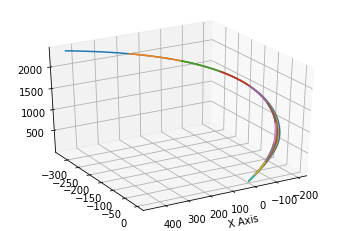

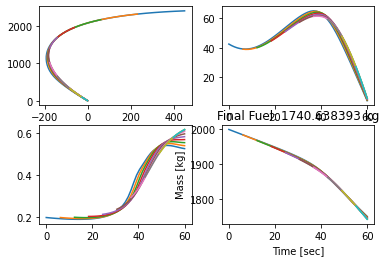

In [7]:
# Print result.
# print("\nThe optimal value is", min_land_err_prob.value)
# print("Solution to the X State is")

fig1 = plt.figure()
ax = plt.axes(projection='3d')
i_ary = range(0, n_idx-1, 5)
# i_ary = range(0, 1, 1)

for i in i_ary:
  x_t_sln = x_t_hist[i,:,:n_idx-i]
  z_t_sln = z_t_hist[i,:,:n_idx-i]
  u_t_sln = u_t_hist[i,:,:n_idx-i]

  m_t = np.exp(z_t_sln)
  T_t = np.multiply(u_t_sln, m_t)

  ax.plot3D(x_t_sln[1,:],  x_t_sln[2,:], x_t_sln[0,:])
  plt.xlabel('Y Axis')
  plt.xlabel('Z Axis')
  plt.xlabel('X Axis')

ax.view_init(30, 60)

fig2 = plt.figure()
s1 = plt.subplot(2,2,1)
s2 = plt.subplot(2,2,2)
s3 = plt.subplot(2,2,3)
s4 = plt.subplot(2,2,4)

for i in i_ary:
  x_t_sln = x_t_hist[i,:,:n_idx-i]
  z_t_sln = z_t_hist[i,:,:n_idx-i]
  u_t_sln = u_t_hist[i,:,:n_idx-i]
  t_sln   = t_hist[i,:,:n_idx-i]
  
  m_t = np.exp(z_t_sln)
  T_t = np.multiply(u_t_sln, m_t)

  s1.plot(x_t_sln[1,:], x_t_sln[0,:])
  plt.ylabel('X Axis (Altitude) [m]')
  plt.xlabel('Y Axis')

  s2.plot(t_sln[0,:], np.linalg.norm(x_t_sln[3:5+1,:], axis=0))
  plt.ylabel('Velocity Magnitude [m/s]')
  plt.xlabel('Time [sec]')

  s3.plot(t_sln[0,:], np.linalg.norm(T_t, axis=0) / T_max)
  plt.ylabel('Max Thrust Percentage [%]')
  plt.xlabel('Time [sec]')

  s4.plot(t_sln[0,:], m_t[0,:])
  plt.ylabel('Mass [kg]')
  plt.xlabel('Time [sec]')
  plt.title('Final Fuel: %f kg' % (m_t[0,-1]))

plt.rcParams['figure.figsize'] = [20, 10]

In [8]:
# Define the Convex Relaxed Minimum Fuel Problem 

# Take the final optimal position from the Minimium Landing Error Problem
dp3 = x_t[1:2+1,-1].value # Only extract the y and z components since x is altitude

In [9]:
# Define the objective function
min_fuel_obj  = cp.Minimize(cp.sum(sigma_t))

# Cannot get variable mass to work correctly
min_fuel_const = [
                      cp.norm( E * x_t[0:2+1,-1] - q ) <= cp.norm(dp3 - q),
                      x_t[0:2+1,0] == r_0,                                       # (8)
                      x_t[3:5+1,0] == dr_0,                                     # (8)
                      cp.multiply(e1, x_t[0:2+1,-1]) == 0,                       # (9)
                      x_t[3:5+1,-1] == 0,                                        # (9) 
                      dx_t == A_w * x_t[:,0:n] + B * (np.matlib.repmat(g.T, n, 1).T + u_t ), # (17) 
                      x_t[:,1:n+1] == x_t[:,0:n] + dx_t * tstep,                # Need to update the position and velocity based on the change in states
                      # Slack variable substitute to resolve T(t)/m(t) nonconvexity
                      # Revised mass flow constraints
                      z_t[0,0] == np.log(m_0),                                   # (7)
                      z_t >= np.log(m_f),                                        # (7)
                      dz_t[0,:] == -alpha * sigma_t[0,0:n],                      # (33)
                      z_t[0,1:n+1] == z_t[0,0:n] + dz_t[0,:] * tstep,            # Need to update the mass based on the change in states

                      cp.norm(u_t, axis=0) <= sigma_t[0,:],                      # (34)
                      n_hat * u_t >= np.cos(theta) * sigma_t[0,:],               # (34) # Should substitute n_hat with an actual value

                      # Revised control constraints
                      rho_1 * np.exp(-z_0[0]) * ((1 - (z_t[0,0:n] - z_0)) + cp.power((z_t[0,0:n] - z_0),2) / 2) <= sigma_t[0,:],
                      sigma_t[0,:] <= rho_2 * np.exp(-z_0[0]) * (1 - (z_t[0,0:n] - z_0)),
                      ]       # (19)


# Include Glide Constraints
min_fuel_const = min_fuel_const + glide_const

min_fuel_prob = cp.Problem(min_fuel_obj, min_fuel_const)

NameError: ignored

In [ ]:
min_fuel_prob.solve()  # Returns the optimal value.

In [ ]:
# Print result.
print("\nThe optimal value is", min_land_err_prob.value)
print("Solution to the X State is")

x_t_sln = x_t.value
m_t = np.exp(z_t[0,:-1].value)
T_t = np.multiply(u_t[:,:].value, m_t)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(x_t_sln[1,:-1],  x_t_sln[2,:-1], x_t_sln[0,:-1],  'gray')
plt.xlabel('Y Axis')
plt.xlabel('Z Axis')
plt.xlabel('X Axis')
ax.view_init(30, 30)

fig = plt.figure()
plt.subplot(2,2,1)
plt.plot(x_t_sln[1,:-1], x_t_sln[0,:-1])
plt.ylabel('X Axis (Altitude) [m]')
plt.xlabel('Y Axis')

plt.subplot(2,2,2)
plt.plot(ts, np.linalg.norm(x_t_sln[3:5+1,:-1], axis=0))
plt.ylabel('Velocity Magnitude [m/s]')
plt.xlabel('Time [sec]')

plt.subplot(2,2,3)
plt.plot(ts, np.linalg.norm(T_t, axis=0) / T_max)
plt.ylabel('Max Thrust Percentage [%]')
plt.xlabel('Time [sec]')

plt.subplot(2,2,4)
plt.plot(ts, m_t)
plt.ylabel('Mass [kg]')
plt.xlabel('Time [sec]')
plt.title('Final Fuel: %f kg' % (m_t[-1]))

plt.rcParams['figure.figsize'] = [20, 10]